Determining the worst winter ever in Chicago
===

The object of this exercise is to take weather observations from past winters in Chicago and determine which of them could be considered the worst winter ever. Various criteria will be used, such as the number of days below zero degrees (F) and the number of days with heavy snowfall, and a Badness Index will be assigned to each winter using these criteria.

Collecting data from NOAA National Climate Data Center
---

NOAA has some great weather records. These data points come from the weather station at Midway airport, starting in 1928 (measurements at O'Hare start around 1962). Here we do some data wrangling of a file I pulled from NOAA-NCDC at http://www.ncdc.noaa.gov/cdo-web/datatools. The data is directly available here: https://github.com/MarcKjerland/Worst-Winter-Ever/blob/master/chicago-midway-noaa.csv.

Here I've defined winter as November through March. Your definition may vary! Some of the variables would translate well to an expanded winter season. Further criteria could be added to highlight painfully long winters or miserable holiday travel conditions, for example.

In [1]:
import pandas as pd
# Read data, sort by year & month
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')
noaa_monthly = pd.read_csv('chicago-midway-noaa.csv', index_col=2,
                           parse_dates=True, date_parser=dateparse, na_values=-9999)
noaa_monthly = noaa_monthly.groupby([noaa_monthly.index.year, noaa_monthly.index.month]).sum()
# Sum seasonal totals
winter_vars = ['MNTM','EMNT','DT00','DX32','MXSD','EMXP','TSNW','DP10']
year_start = 1928
year_end = 2013
season_start = 11 #November
season_end = 3 #March
noaa_winters = pd.concat(
    [noaa_monthly.loc[(year, season_start):(year+1, season_end), winter_vars].sum(axis=0)
    for year in range(year_start, year_end+1)], axis=1).transpose()
noaa_winters.index = range(year_start, year_end+1)
# Fix variables that should have been handled differently
noaa_winters['TSNW'] /= 24.4
for year in noaa_winters.index:
    noaa_winters.loc[year, 'MNTM'] = \
        noaa_monthly.loc[(year, season_start):(year+1, season_end), 'MNTM'].mean() * 0.18 + 32
    noaa_winters.loc[year, 'EMNT'] = \
        noaa_monthly.loc[(year, season_start):(year+1, season_end), 'EMNT'].min() * 0.18 + 32
    noaa_winters.loc[year, 'MXSD'] = \
        noaa_monthly.loc[(year, season_start):(year+1, season_end), 'MXSD'].max() / 24.4
    noaa_winters.loc[year, 'EMXP'] = \
        noaa_monthly.loc[(year, season_start):(year+1, season_end), 'EMXP'].max() / 24.4

Definition of variables
---
Here are the variables used to determine which Chicago winter was the worst. In the future I'd love to include others related to wind chill, cloud cover, high gusts, freezing rain, and other wintery hazards, but this monthly NCDC dataset didn't include them. Perhaps the daily figures are worth looking into.

The units are American: inches and Fahrenheit.

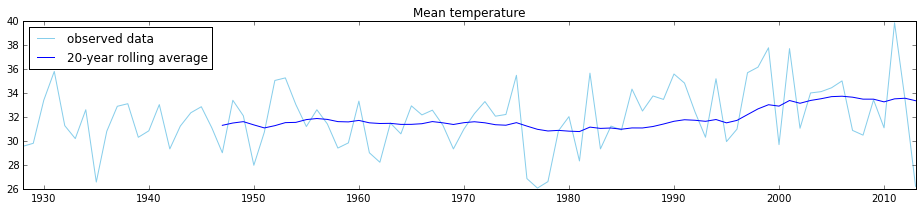

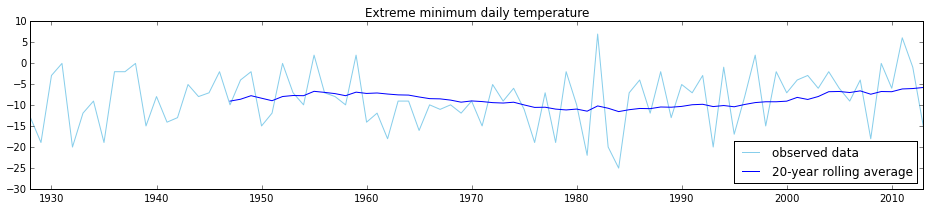

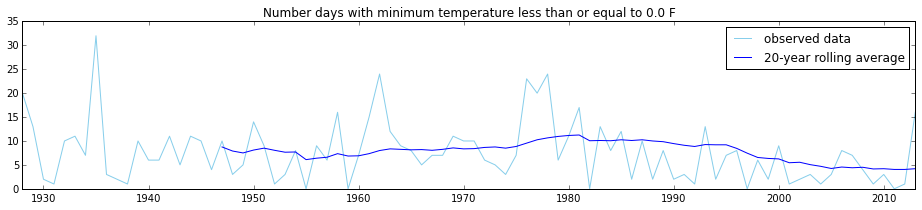

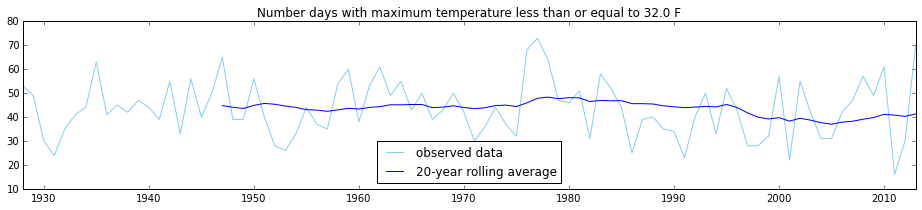

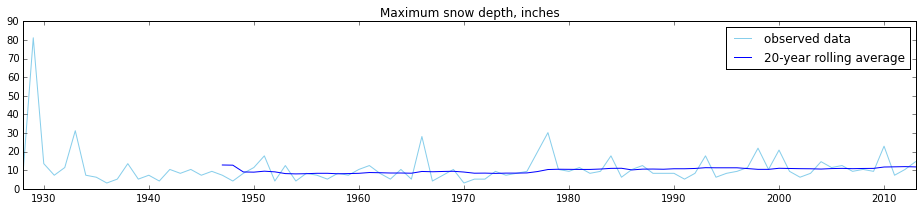

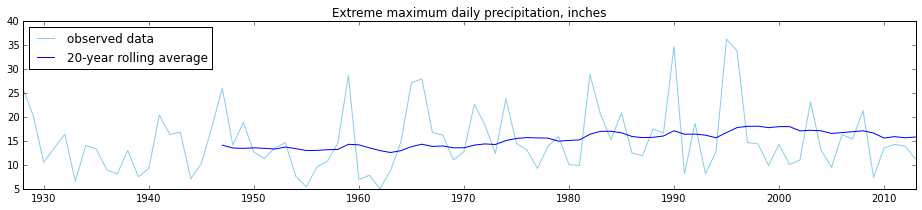

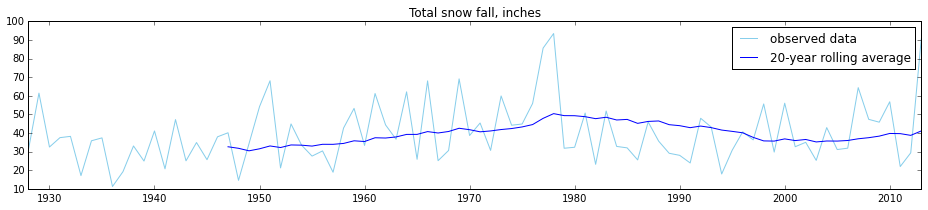

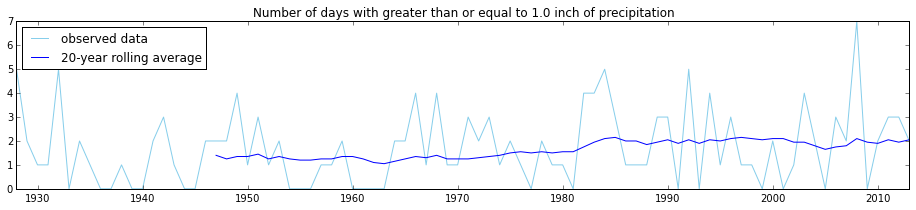

In [2]:
acronym = { 'DP10': 'Number of days with greater than or equal to 1.0 inch of precipitation',
            'MXSD': 'Maximum snow depth, inches',
            'EMXP': 'Extreme maximum daily precipitation, inches',
            'DT00': 'Number days with minimum temperature less than or equal to 0.0 F',
            'DX32': 'Number days with maximum temperature less than or equal to 32.0 F',
            'EMNT': 'Extreme minimum daily temperature',
            'TSNW': 'Total snow fall, inches',
            'MNTM': 'Mean temperature'}
# Plot variables
import matplotlib.pyplot as plt
%matplotlib inline
for v in noaa_winters.columns:
    noaa_winters[v].plot(figsize=(16,3), color='skyblue');
    pd.rolling_mean(noaa_winters[v], 20).plot(color='blue')
    plt.title(acronym[v])
    plt.legend(["observed data", "20-year rolling average"], loc='best')
    plt.show()

The Badness Index of each winter
---

To determine the badness index for a particular winter, first we assign to each of its variables a score from 0 to 100. A score of 100 means it was the worst or coldest recorded value (for example, more snowfall than any other winter) and a score of 0 means it was the least bad or warmest recorded value (for example, less snowfall than any winter); otherwise the variable will get a score somewhere in between (on a linear scale). Then each winter is assigned a badness index equal to the average of each of its variable scores, ranging from 0 to 100.

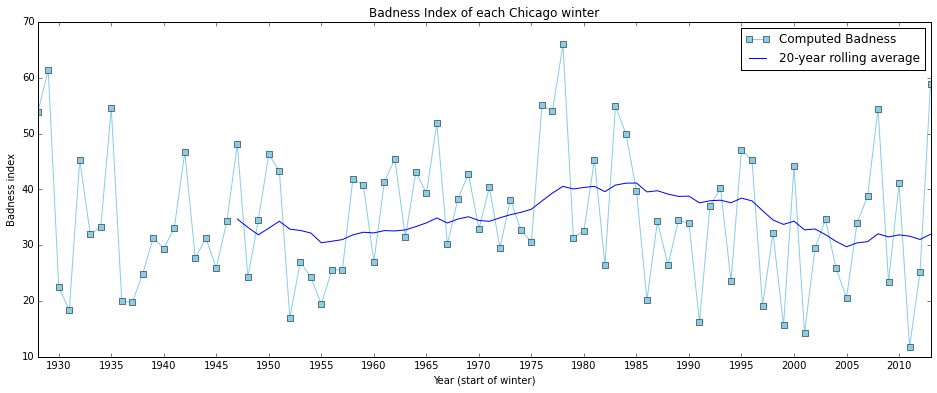

In [3]:
# Find the best & worst for each variable
winter_coldest = pd.Series(index=noaa_winters.columns)
winter_warmest = pd.Series(index=noaa_winters.columns)
# For these variables, big is bad
for v in ['MXSD','EMXP','DT00','DX32','TSNW','DP10']:
    winter_coldest[v] = noaa_winters[v].max()
    winter_warmest[v] = noaa_winters[v].min()
# For these variables, small (or negative) is bad
for v in ['MNTM','EMNT']:
    winter_coldest[v] = noaa_winters[v].min()
    winter_warmest[v] = noaa_winters[v].max()
# Assign scores to each year
winter_score = 100 * (noaa_winters-winter_warmest).abs() / (winter_coldest-winter_warmest).abs()
badness = winter_score.mean(axis=1)
# Plot the Badness Index
badness.plot(figsize=(16,6), marker='s', color='skyblue', xticks=badness.index[2::5])
pd.rolling_mean(badness, 20).plot(color='blue')
plt.title("Badness Index of each Chicago winter")
plt.ylabel("Badness index")
plt.xlabel("Year (start of winter)")
plt.legend(["Computed Badness", "20-year rolling average"])
plt.show()

There you have it! Some candidates for Worst Winter Ever can be determined by the highest peaks. The winter of 2013-14 was pretty bad, but it paled in comparison to the winter of 1978-79 and possibly also 1929-30.

Bonus Statistical Analysis (under construction)
---

Here we'll dive into some Principal Component Analysis, which basically extracts the most prominent trends from all the variables for further inspection. Check Wikipedia for more info.

Explained variance ratios: [ 0.43921202  0.20345464  0.12742928  0.09083164]


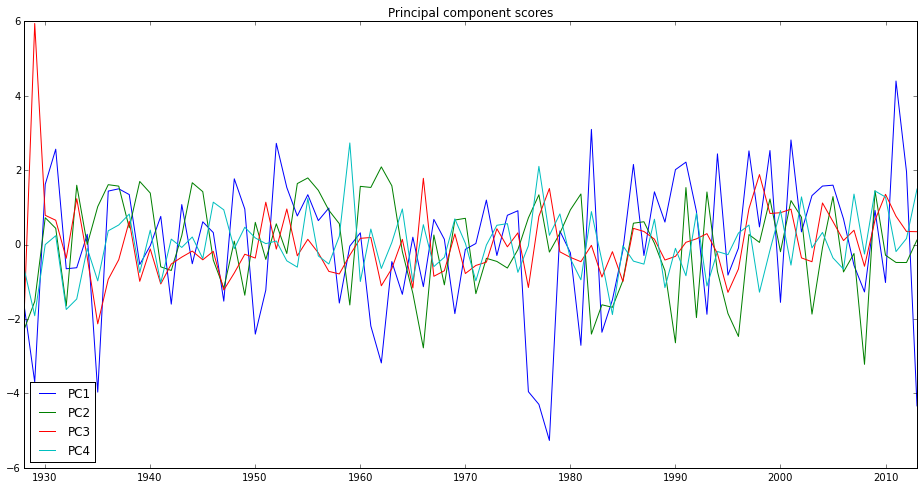

In [4]:
z = (noaa_winters - noaa_winters.mean()) / noaa_winters.std()
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(z)
pca_components = pd.DataFrame(pca.components_, index=['PC'+str(i) for i in range(1,pca.n_components_+1)], \
                              columns=z.columns)
pca_scores = pd.DataFrame(pca.transform(z), index=z.index, columns=pca_components.index )
print "Explained variance ratios:", pca.explained_variance_ratio_
pca_scores.plot(figsize=(16,8))
plt.legend(loc='best')
plt.title('Principal component scores')
plt.show()

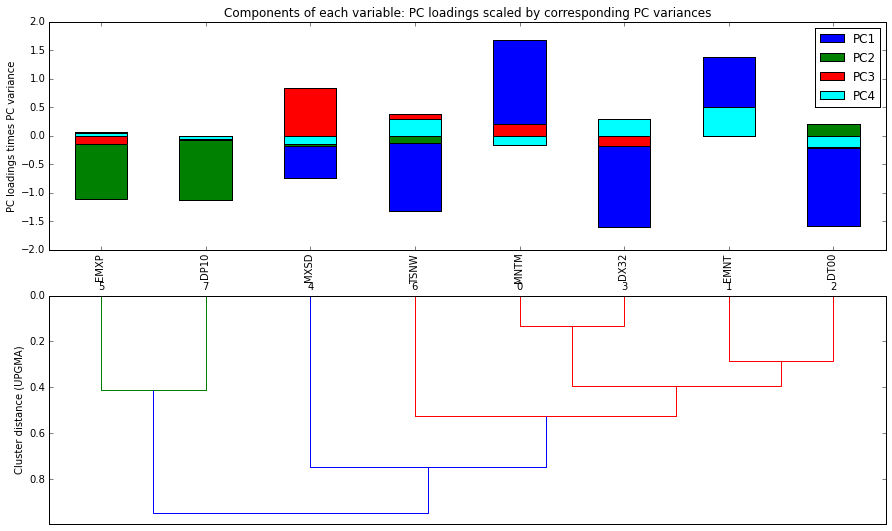

In [5]:
# Cluster analysis
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
dissimilarity = 1 - noaa_winters.corr().abs()
row_distance = np.clip(squareform(dissimilarity),0,1)
L = linkage(row_distance, method='average')
plt.figure(figsize=(15,9), dpi=100)
plt.subplot(212)
R = dendrogram(L, orientation='bottom')
plt.ylabel('Cluster distance (UPGMA)')
# Matched up with PC loadings (scaled by corresponding PC variances)
leaves = [pca_components.columns[i] for i in R['leaves']]
plt.subplot(211)
(pca_components[leaves].iloc[0] * pca.explained_variance_[0]).plot(kind='bar', color='blue')
(pca_components[leaves].iloc[1] * pca.explained_variance_[1]).plot(kind='bar', color='green')
(pca_components[leaves].iloc[2] * pca.explained_variance_[2]).plot(kind='bar', color='red')
(pca_components[leaves].iloc[3] * pca.explained_variance_[3]).plot(kind='bar', color='cyan')
plt.ylabel('PC loadings times PC variance')
plt.legend(loc='best')
plt.title('Components of each variable: PC loadings scaled by corresponding PC variances')
plt.show()